In [1]:
## Interactive magics
%matplotlib inline
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import patsy as pt
import pymc3 as pm

plt.rcParams['figure.figsize'] = 14, 6
np.random.seed(0)
print('Running on PyMC3 v{}'.format(pm.__version__))

/Users/marysilva/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Running on PyMC3 v3.5


In [8]:
df = pd.read_csv("fabric.txt", delimiter=",")

In [9]:
df

,length,faults
0,551,6
1,651,4
2,832,17
3,375,9
4,715,14
5,868,8
6,271,5
7,630,7
8,491,7
9,372,7


In [4]:
# From: Bayesian Models for Astrophysical Data, Cambridge Univ. Press
# (c) 2017,  Joseph M. Hilbe, Rafael S. de Souza and Emille E. O. Ishida 
# 
# you are kindly asked to include the complete citation if you used this 
# material in a publication

# Code 6.7 - Bayesian Poisson model using pure Python
# 1 response (py) and 2 explanatory variables (x1_2, x2)

import numpy as np
import pandas
import pylab as plt
import pymc3 as pm

from scipy.stats import norm, binom, poisson



In [10]:
x1 = df['length']
py = df['faults']

In [11]:
# Fit
niter = 10000                        # parameters for MCMC

with pm.Model() as model_glm:
    # define priors
    beta0 = pm.Flat('beta0')
    beta1 = pm.Flat('beta1')

    # define likelihood
    mu = np.exp(beta0 + beta1*x1)
    y_obs = pm.Poisson('y_obs', mu, observed=py)

    # inference
    start = pm.find_MAP()             # Find starting value by optimization
    step = pm.NUTS()
    trace = pm.sample(niter, step, start, progressbar=True)


logp = -inf, ||grad|| = 0: 100%|██████████| 84/84 [00:00<00:00, 759.94it/s]    
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta1, beta0]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:39<00:00, 525.53draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [39]:
# Output
pm.summary(trace)[['mean', 'sd', 'hpd_2.5','hpd_97.5']]

,mean,sd,hpd_2.5,hpd_97.5
beta0,0.965088,0.211464,0.563064,1.384523
beta1,0.001934,0.000304,0.001328,0.002520


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ebc6240>,
      dtype=object)

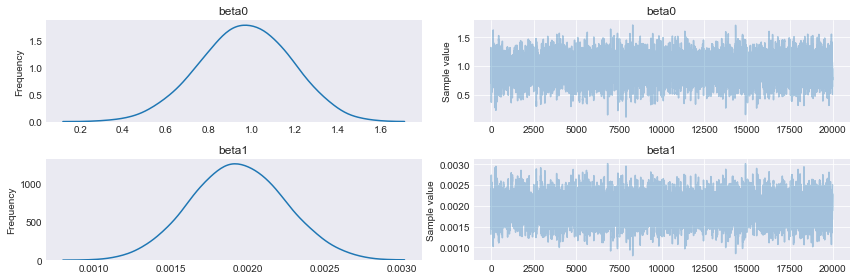

In [38]:
# show graphical output
pm.traceplot(trace, combined = True)

In [104]:
xmin=np.min(x1)
xmax=np.max(x1)
xp = np.linspace(xmin, xmax, 100)
poisson_link = lambda b0, b1, xp: np.exp(b0 + b1*xp)
p_result = poisson_link(0.965088, 0.001934, xp)
lower = pd.read_csv("lower.txt")
lower = lower['x']
upper = pd.read_csv("upper.txt")
upper = upper['x']

Text(0.5,1,'Poisson GLM')

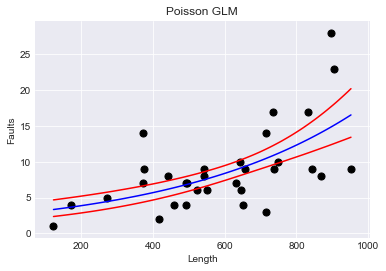

In [115]:
# begin plot
fig, ax = plt.subplots()
ax.plot(xp, p_result, c='blue', label = 'poisson glm')
ax.plot(xp, lower, c='red')
ax.plot(xp, upper, c='red', )
# ax.plot(xp, p_result + np.sqrt(std_res), c='red')

# plt.legend = ax.legend(loc='upper left')
plt.scatter(x1, py, s=50, c='black');

plt.xlabel('Length')
plt.ylabel('Faults')
plt.title('Poisson GLM')

In [118]:
ppc = pm.sample_ppc(trace, samples=1000, model=model_glm)

100%|██████████| 1000/1000 [00:01<00:00, 829.65it/s]


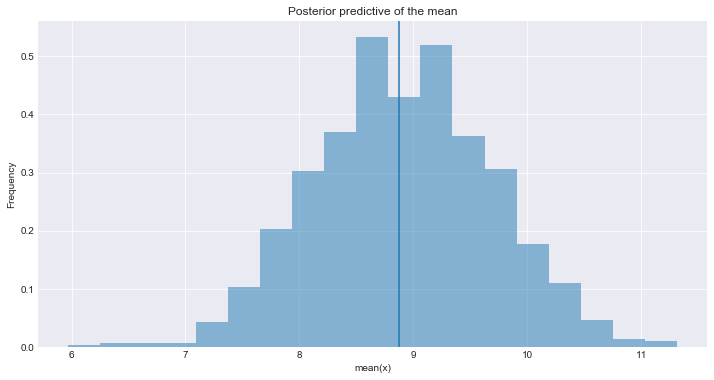

In [119]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in ppc['y_obs']], bins=19, alpha=0.5, density=True)
ax.axvline(py.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

In [ ]:
import seaborn as sns
post_means = np.mean(ppc['y_obs'],axis=0)
plt.hist(post_means)

In [ ]:
sns.distplot(post_means, norm_hist = True)